In [1]:
import pandas as pd

dados = pd.read_csv('/kaggle/input/rio-de-janeiro-airbnb-listings-2022/AirbnbRJRentals.csv')
dados

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
0,10463735,Sobrado aconchegante e espaçoso,53918534,Quiá,Laranjeiras,-22.935550,-43.191070,Entire home/apt,581,1,2,2018-02-14,0.03,6,181,0
1,53887789,Quadra da praia,333527901,Lucas,Copacabana,-22.970320,-43.180810,Entire home/apt,898,5,0,NaN,NaN,2,365,0
2,783493769216852616,"Leme, Brasil",491704706,Felipe,Leme,-22.964210,-43.171600,Entire home/apt,720,1,0,NaN,NaN,2,362,0
3,703973293620197060,Suíte com entrada independente em casarão 1,20362236,Júlio Cesar,Botafogo,-22.957920,-43.182226,Private room,599,4,1,2022-09-06,0.26,4,363,1
4,782895997622988215,Apartamento próximo ao metrô,302417043,Laís,Laranjeiras,-22.931960,-43.180180,Entire home/apt,240,3,0,NaN,NaN,1,160,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28296,689013693819928481,Apartamento no Recreio para o Rock in Rio,472932703,Adriana,Recreio dos Bandeirantes,-23.018124,-43.466737,Entire home/apt,871,3,1,2022-09-10,0.27,1,365,1
28297,23414904,Nice tranquil apartment in Copacabana,100247568,Cecilia,Copacabana,-22.960430,-43.174090,Entire home/apt,194,2,50,2022-09-05,0.86,1,259,8
28298,48489080,Praia de Botafogo ao lado do Metrô,172482654,Evilene,Botafogo,-22.945580,-43.183610,Entire home/apt,153,15,18,2022-11-20,0.95,13,58,9
28299,43109156,Lindo apart. 250 mega internet a 300m Praia Leme,46082356,Patrícia,Botafogo,-22.959110,-43.178380,Entire home/apt,457,10,19,2022-12-03,0.60,4,204,10


In [2]:
dados_limpos = dados.dropna()
dados_limpos.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,1.978100e+04,1.978100e+04,19781.000000,19781.000000,19781.000000,19781.000000,19781.000000,19781.000000,19781.000000,19781.000000,19781.000000
mean,1.623352e+17,1.365249e+08,-22.968590,-43.244732,1208.160710,3.959001,25.040898,0.894192,8.602497,190.993529,8.808453
std,2.867422e+17,1.465510e+08,0.033421,0.095396,7355.949295,20.428644,43.059332,1.026601,24.374662,131.770325,11.802266
min,1.787800e+04,3.607000e+03,-23.072840,-43.689910,0.000000,1.000000,1.000000,0.010000,1.000000,0.000000,0.000000
25%,1.607912e+07,1.563791e+07,-22.984590,-43.289610,300.000000,2.000000,3.000000,0.190000,1.000000,65.000000,1.000000
50%,4.102455e+07,7.290590e+07,-22.973380,-43.194110,557.000000,2.000000,9.000000,0.540000,2.000000,176.000000,4.000000
75%,5.424722e+07,2.294729e+08,-22.960800,-43.185577,971.000000,3.000000,27.000000,1.240000,4.000000,329.000000,12.000000
max,7.900352e+17,4.918992e+08,-22.749690,-43.104400,500000.000000,999.000000,563.000000,18.170000,228.000000,365.000000,174.000000


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(0.0, 30000.0)

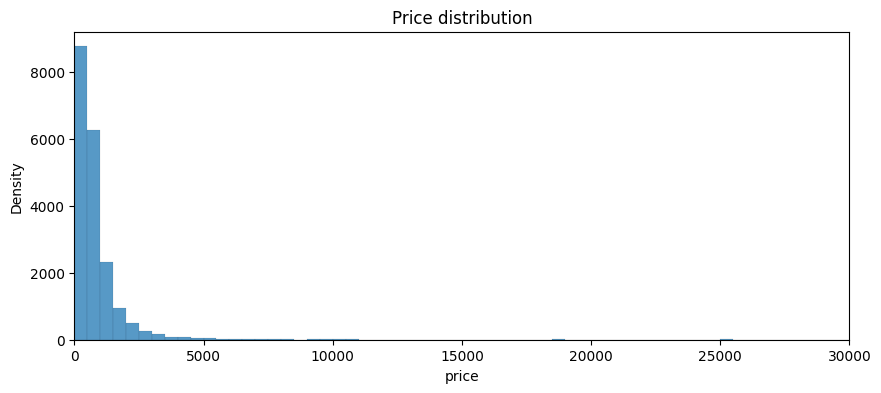

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1) = plt.subplots(ncols = 1, sharey = False, figsize = (10, 4))

sns.histplot(dados_limpos['price'], kde = False, ax = ax1, bins=1000)

ax1.grid(False)
ax1.set_title('Price distribution')
ax1.set_ylabel('Density')
ax1.set_xlim(0, 30000)

# sns.boxplot(dados_limpos['price'], ax = ax2)

# ax2.grid(False)
# ax2.set_title('Price outliers');